In [ ]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
#rc('text', usetex=True) # para usar latex en matplotlib

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra y Vicente Salinas

**Integrantes:** Diego Dominguez, Branco Paineman y Sebastián Rojas 

# Laboratorio 1

El objetivo de esta sesión práctica es aprender a resolver EDP’s en 2
dimensiones mediante el Método de las Diferencias Finitas.

Específicamente se resolverá la ecuación de Poisson en un rectángulo unitario y en un dominio perforado, además se estudiará la aproximación para condiciones de borde en dominios con curvatura

# Parte a


## Ecuación de Poisson

Considere la ecuación dada por

$$
\begin{equation}
\left.
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left[  0,1\right]^{2}\\
u(0,y)=u(1,y)= & 0 & \text{en }0\leq y\leq 1\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1
\end{array}
\right\} \quad (1)
\end{equation}
$$

Sea $N\in\mathbb{N}$, considere la aproximación del cuadrado unitario dado por la malla de puntos
$$
\Omega_{h}=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  \right\}
$$
donde $x_{j}=jh$, $y_{k}=kh$, $h=\dfrac{1}{N+1}$. Se define el operador laplaciano discretizado por 5 puntos como
$$
\Delta_{N}u_{j,k}=\dfrac{1}{h^{2}}\left(  u_{j+1,k}+u_{j-1,k}
+  u_{j,k-1}+u_{j,k+1}
-4u_{jk}\right)
$$
donde $u_{jk}$ aproxima a $u\left(x_{j},y_{k}\right)  $.

Tomando $g(x) = \sin(\pi x)$, se puede demostrar que la solución única de esta ecuación está dada por

$$u\left(  x,y\right)  =\frac{\sin\left( \pi x\right)   \sinh\left( \pi y\right)  }{\sinh\left(  \pi\right) } $$

**P1.** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ de la forma más simple posible. Las entradas para estas funciones deben ser $N$ y $g$.

También escriba una función `solve` que, utilizando estas funciones (y las funciones auxiliares que necesite), entregue la solución aproximada.

**Indicación.** Revise la documentación del comando `kron` (disponible a través de `scypy.sparse`)

In [ ]:
def Ah(N):###Funcion que crea Ah
    e = np.ones(N) ##Diagonal
    f = np.ones(N-1)##Diagonales superior e inferior
    k = np.array([-f,4*e,-f], dtype= object) 
    offset = [-1,0,1] 
    L4 = sp.sparse.diags(k,offset) ##Se crea la matriz L4 segun la tarea 1
    I_ = -spsp.identity(N).toarray()
    A=np.kron(np.eye(N,k=-1),I_)+np.kron(np.eye(N),L4.todense())+np.kron(np.eye(N,k=1),I_)##Se crea la matriz A
    h=1/(N+1)
    return ((1/h)**2)*(A)


def bh(N,f,g):###Se crea el vector B_h
    xx = np.linspace(0,1,N+2)[1:-1]
    yy = np.linspace(0,1,N+2)[1:-1]
    
    #Ahora definimos una grilla.
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    F = f(X,Y) ##funcion f evaluada en la grilla
    F=np.reshape(F,(1,N**2))
    G = np.zeros(N**2)
    G[-N:]=g(xx)
    h=1/(N+1)
    b=F+G/h**2##Se implementa b segun la definision de la tarea 1
    b=b[0]
    return b

def solve(N, f, g):
    """Resuelve el problema del laplaciano en 2D en (0,1)^2, con condiciones
    Dirichlet en el borde, usando una grilla uniforme, con tamano de
    paso h=1/N en x e y.
    """
    A=Ah(N)
    b=bh(N,f,g)
    X,Y=b[1],b[2]
    return np.linalg.solve(A,b)

In [ ]:
#Test
f = lambda x,y: x-x
g = lambda x:np.sin(x*np.pi)

In [ ]:
u = lambda x,y:np.sin(x*np.pi)*np.sinh(y*np.pi)/np.sinh(np.pi)

**P2.** Resuelva la ecuación para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [ ]:
Ns=[10,20,30,40,50]
Resultados_aprox=[]
Valor_real=[]
Errores=[]
for n in Ns:
    s=solve(n,f,g)
    aprox=s
    xx = np.linspace(0,1,n+2)[1:-1]
    yy = np.linspace(0,1,n+2)[1:-1]
    
    #Ahora definimos una grilla.
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    U=u(X,Y)
    U=np.reshape(U,(1,n**2))
    real=U[0]
    Resultados_aprox.append(aprox)
    Valor_real.append(real)
    error=np.linalg.norm(real-aprox,2)
    Errores.append(error)

In [ ]:
def visualiza1(resultados):
    global g
    N=int(np.sqrt(len(resultados)))
    resultados_=np.reshape(resultados,(N,N))
    M=np.zeros((N+2,N+2))
    M[1:-1,1:-1]=resultados_
    x=np.linspace(0,1,N+2)
    M[-1,:]=g(x)
    
    #Ahora definimos una grilla.
    xx = np.linspace(0,1,N+2)
    yy = np.linspace(0,1,N+2)
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    fig = plt.figure(figsize=(10,7))
    ax  = Axes3D(fig)
    ax.plot_surface(X, Y, M, alpha= 0.9, cmap='jet')
    ax.set_proj_type('ortho') #Ángulo en que se mira el gráfico
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Valor de u')
    ax.set_title('Solución para N='+str(N))
    plt.show()

<ipython-input-81-7e11f30271b7>:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax  = Axes3D(fig)


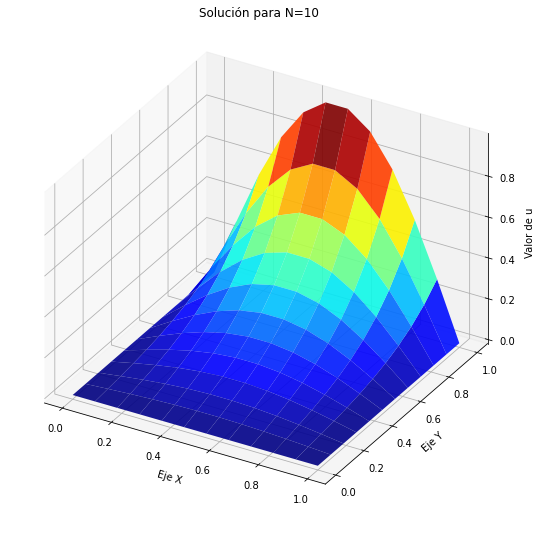

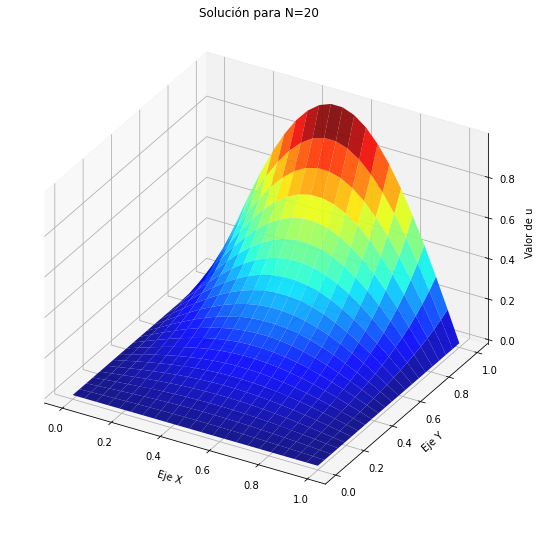

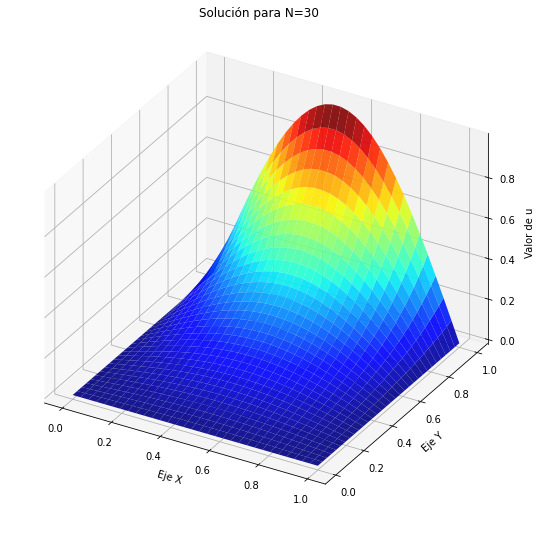

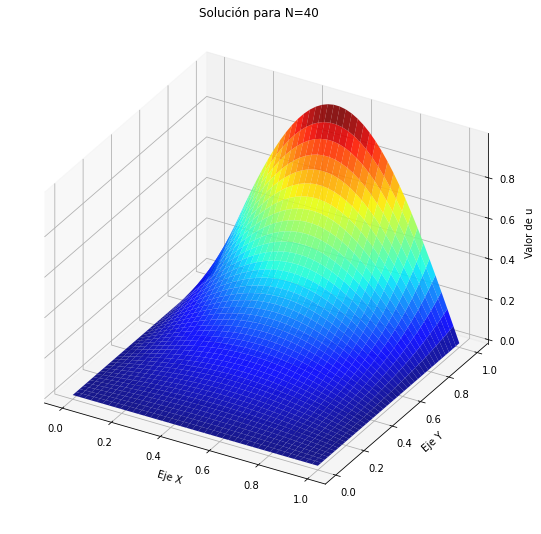

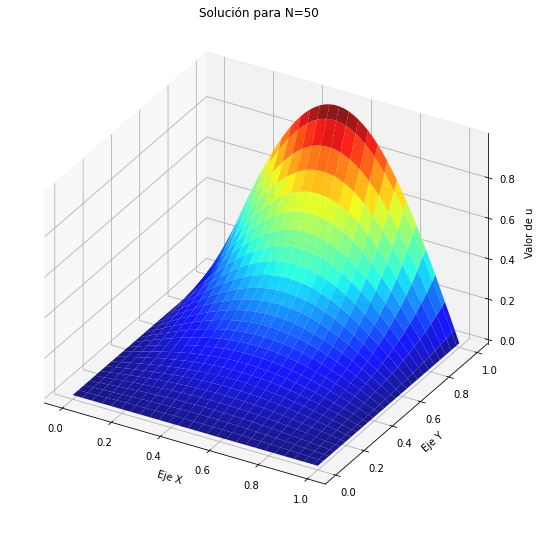

In [ ]:
for resultados in Resultados_aprox:
    M=visualiza1(resultados)

## Errores según N

In [ ]:
pd.DataFrame({'N': Ns, 'Error':Errores}) 

,N,Error
0,10,0.012507
1,20,0.006587
2,30,0.004467
3,40,0.003379
4,50,0.002717


<ipython-input-83-3d38fb49901f>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax  = Axes3D(fig)


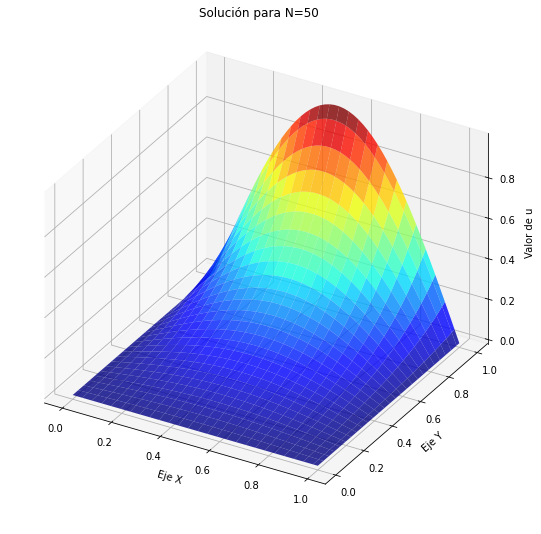

In [ ]:
N=50
xx = np.linspace(0,1,N+2)
yy = np.linspace(0,1,N+2)
X, Y = np.meshgrid(xx, yy, indexing= 'xy')
U=u(X,Y)
fig = plt.figure(figsize=(10,7))
ax  = Axes3D(fig)
ax.plot_surface(X, Y, U, alpha= 0.8, cmap='jet')
ax.set_proj_type('ortho') #Ángulo en que se mira el gráfico
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Valor de u')
ax.set_title('Solución para N='+str(N))
plt.show()

Comentario: Se observa que a medida que aumenta el tamaño el valor de N, las particiones de la grilla se vuelven más finas, de ahí que el valor entregado por la solución aproximada se acerca más al valor real, en particular en la parte anterior se puede observar una tabla con los errores cometidos segun N, donde se observa este comportamiento . 

**P3.** Estudie el condicionamiento en norma $2$ de la Matriz $A_h$.

**Indicación.** Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como
$$
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
$$
y, si $\boldsymbol{A}$ es invertible, el número de condición en norma inducida $p$ como $\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}$.

En este caso particular, como $\boldsymbol{A}_{h}$ es simétrica, el número de condición en la norma $2$ inducida puede calcularse como
$$
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
$$
donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  =\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

In [ ]:
def cond_2_sparse(A):##Se implementa la funcion cond_2_sparse que calcular el condicionamiento de la Matriz A_{h}
    """
    Calcula el numero de condicionamiento en norma inducida 2
    para una matriz sparse simetrica A.
    Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo
    
    Input:
    - A matriz sparse simetrica
    
    Documentacion de eigsh:
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
    """
    
    vp=eigsh(A)[0]##Se calculan los valores propios 
    maxi=max(vp)
    mini=min(vp)
    cond=maxi/mini##Formulacion del condicionamiento para una matriz simetrica
    return cond

## Condicionamiento de la matriz A

In [ ]:
cond_Ns=np.zeros(len(Ns))
for i in range(len(Ns)):##Condicionamiento de la matriz para los distintos Ns
    cond_Ns[i]=cond_2_sparse(Ah(Ns[i]))

cond_Ns

array([1.08428401, 1.02258778, 1.010314  , 1.00588562, 1.00380054])

El condicionamiento de la matriz se interpreta como la variación en el error relativo de la solución asociada, de esta forma se puede observar como a medida que la partición se va haciendo cada vez más fina los valores tienden a disminuir, es decir, el error relativo decae. 

# Parte b

## Ecuación en Dominios Perforados

Para $\Omega = [0, 1]^2\backslash B ((0.5, 0.5), 0.3)$, considere:
$$
\left(  P \right)  \left\{
\begin{array}
[c]{ccc}
-\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
\end{array}
\right.
$$

y $g$ dada por:

$$
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{cc}
2  & \text{si }(x,y) \in \partial [0,1]^2 \\
0  & \text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
$$






**P1.** Genere una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un
punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos.

In [ ]:
def y_interior(x_j,y_k,N):##Funcion que entrega 0 si la posicion y_k o sus vecinos estan al interior de la perforacion, caso contrario 1
    h=1/(N+1)
    vecinos=np.array([y_k-h,y_k,y_k+h])
    r=(x_j-0.5)**2+(vecinos-0.5)**2
    r=np.where(r<0.30**2,0,1)
    return r[0]*r[1]*r[2]

def x_interior(x_j,y_k,N):##Funcion que entrega 0 si la posicion y_k o sus vecinos estan al interior de la perforacion,caso contrario 1
    h=1/(N+1)
    vecinos=np.array([x_j-h,x_j,x_j+h])
    r=(vecinos-0.5)**2+(y_k-0.5)**2
    r=np.where(r<0.30**2,0,1)
    return r[0]*r[1]*r[2]

def indicatriz_interior(x_j,y_k,N):
    ind1=y_interior(x_j,y_k,N)
    ind2=x_interior(x_j,y_k,N)
    return ind1*ind2

def coef(h,d):##Funcion que calcula los coeficientes del sistema de ecuaciones para aproximar segundas derivadas de puntos cercanos a la perforacion
    alpha=2/(h*(d+h))
    gamma=2/(d*(d+h))
    beta=-alpha-gamma
    return alpha,beta,gamma

**P2.** Asuma que la matriz del sistema es de la forma $A = A_x + A_y$, donde $A_x$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$ y lo equivalente para $A_y$. Encuentre la forma
que deben tener $A_x$ y $A_y$ y escriba un programa que calcule dichas matrices.

In [ ]:
def Ahx(N):
    ####Se crea la grilla##
    xx = np.linspace(0,1,N+2)[1:-1]
    yy = np.linspace(0,1,N+2)[1:-1]
    h=1/(N+1)
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    #####################
    a_1=x_interior(X,Y,N)##Se ven que xs se pueden calcular segun la formulacion de 5 puntos
    ####Parametros para crear Ax####
    e = np.ones(N) 
    f = np.ones(N-1)
    k = np.array([-f,2*e,-f], dtype= object) 
    offset = [-1,0,1] 
    L2 = sp.sparse.diags(k,offset) 
    I = -spsp.identity(N).toarray()
    ##################
    Ax=(1/h**2)*np.kron(np.eye(N),L2.todense())##Se crea la matriz Ax, solo depende de valores en su misma columna (no hay Identidades).
    for i in range(N):
        for j in range(N):
            n=N*i+j ####Se recorre la grilla por columnas
            x=X[i][j]
            y=Y[i][j]
            if a_1[i,j]==0:###Si el punto es conflictivo
                if (x-0.5)**2+(y-0.5)**2>0.3**2:### y esta fuera del agujero
                    x_1=0.5+np.sqrt(np.abs(0.3**2-(y-0.5)**2))###Posible punto mas cercano a x
                    x_2=0.5-np.sqrt(np.abs(0.3**2-(y-0.5)**2))###Posible punto mas cercano a x
                    d1=abs(x_1-x)##Distancia entre x y x_1
                    d2=abs(x_2-x)##Distancia entre x y x_1
                    d_=np.array([d1,d2])
                    x_=np.array([x_1,x_2])[np.argmin(d_)]##Distancia mas corta a x
                    d=np.min(d_)
                    alpha,beta,gamma=coef(h,d)##Calculo de coef para la aproximacion
                    if x_<x:##Si el punto esta izquierda de la perforacion
                        if (n+1)%N==0:##Si es condicion de borde de la primera columna en la grilla
                            Ax[n,:]=0
                            Ax[n,n]=-beta
                        else:##Si no es condicion de borde 
                            Ax[n,:]=0
                            Ax[n,n]=-beta
                            Ax[n,n+1]=-alpha 
                    else: ##Si esta a la derecha de la perforacion  
                        if n%N==0:##Si es condicion de borde en la ultima columna de la grilla
                            Ax[n,:]=0
                            Ax[n,n]=-beta
                        else:
                            Ax[n,:]=0
                            Ax[n,n]=-beta
                            Ax[n,n-1]=-alpha
                else:
                    Ax[n,:]=0 ##Si el punto esta dentro del agujero, la columna entera solo son 0s
    return Ax

def Ahy(N):
    xx = np.linspace(0,1,N+2)[1:-1]
    yy = np.linspace(0,1,N+2)[1:-1]
    h=1/(N+1)
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    a_1=y_interior(X,Y,N)##Se ven que Ys se pueden calcular con la formulacion de 5 puntos
    e = np.ones(N) 
    f = np.zeros(N-1)
    k = np.array([f,2*e,f], dtype= object) 
    offset = [-1,0,1] 
    L2 = sp.sparse.diags(k,offset)
    I = -spsp.identity(N).toarray()
    Ay=(1/h**2)*(np.kron(np.eye(N,k=-1),I)+np.kron(np.eye(N),L2.todense())+np.kron(np.eye(N,k=1),I))##Se crea la matriz Ay esta depende de valores que no estan en su mismo bloque (aparecen las identidades).
    for i in range(N):
        for j in range(N):
            n=N*i+j
            x=X[i][j]
            y=Y[i][j]
            if a_1[i,j]==0:##Analogo al caso de Ax
                if (x-0.5)**2+(y-0.5)**2>0.3**2:
                    y_1=0.5+np.sqrt(np.abs(0.3**2-(x-0.5)**2))
                    y_2=0.5-np.sqrt(np.abs(0.3**2-(x-0.5)**2))
                    d1=abs(y_1-y)
                    d2=abs(y_2-y)
                    d_=np.array([d1,d2])
                    y_=np.array([y_1,y_2])[np.argmin(d_)]
                    d=np.min(d_)
                    alpha,beta,gamma=coef(h,d)
                    ######
                    if y_<y:
                        if n>=N**2-N:##Si es condicion de borde en la columna superior de la grilla
                            Ay[n,:]=0
                            Ay[n,n]=-beta
                        else:
                            Ay[n,:]=0
                            Ay[n,n]=-beta
                            Ay[n,n+N]=-alpha 
                    else:   
                        if n<=N:##Si es condicion de borde en la columna inferior de la grilla
                            Ay[n,:]=0
                            Ay[n,n]=-beta
                        else:
                            Ay[n,:]=0
                            Ay[n,n]=-beta
                            Ay[n,n-N]=-alpha
                else:
                    Ay[n,:]=0

    return Ay

**P3.** Escriba una función que calcule $b_h$ adaptado a este caso.

In [ ]:
def bh(N):##Funcion que crea el vector b_h contando todos los indices, solve2 quitara aquellos que no correspondan.
    
    xx = np.linspace(0,1,N+2)[1:-1]
    yy = np.linspace(0,1,N+2)[1:-1]
    
    #Ahora definimos una grilla.
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    
    def g(x,y,N):##Condiciones de borde en la definicion b_h=g_h/h**2
        if x==1/(N+1) or x==N/(N+1) or y==1/(N+1) or y==N/(N+1):
            return 2
        else:
            return 0
        
    G=np.zeros(N**2)##N**2 valores posee el vector (sin sacar aun el resto)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x=X[i,j]
            y=Y[i,j]
            G[i+j*N]=g(x,y,N)##Se reemplaza segun la indexacion de n
    
    h=1/(N+1)
    b=G/h**2
    return b


**P4.** Resuelva el sistema y grafique la solución aproximada para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [ ]:
def solve2(N):
    A=Ahx(N)+Ahy(N)##Se crean las respectivas matrices Ax y Ay
    indices_no_ceros=[]
    for i in range(len(A)):
        if A[i,i]!=0:##Se ven que indices en la diagonal son distinto de 0
            indices_no_ceros.append(i)
    b=bh(N)
    b=b[indices_no_ceros]##Se sacan aquellos indices 0s
    A=A[indices_no_ceros,:]##Se quitan filas y columnas de A
    A=A[:,indices_no_ceros]

    return np.linalg.solve(A,b),indices_no_ceros #Se resuelve el sistema y se entregan los indices(se usa en la visualizacion)

In [ ]:
def visualiza2(resultados,indices,N):##funcion que visualiza los resultados.
    U=np.zeros(N**2)
    U[indices]=resultados
    resultados_=np.reshape(U,(N,N)) 
    M=np.zeros((N+2,N+2))
    M[1:-1,1:-1]=resultados_
    x=np.linspace(0,1,N+2)
    M[-1,:]=2
    M[0,:]=2
    M[:,-1]=2
    M[:,0]=2
    
    #Ahora definimos una grilla.
    xx = np.linspace(0,1,N+2)
    yy = np.linspace(0,1,N+2)
    X, Y = np.meshgrid(xx, yy, indexing= 'xy')
    fig = plt.figure(figsize=(10,7))
    plt.title('Solucion para N='+str(N))
    plt.xlabel('Eje x')
    plt.ylabel('Eje y')
    graf = plt.contourf(X,Y,M, 100, cmap='jet') #El número es la cantidad de curvas de nivel que se desean
    fig.colorbar(graf)
    plt.show()

## Graficos de la solucion para los distintos N

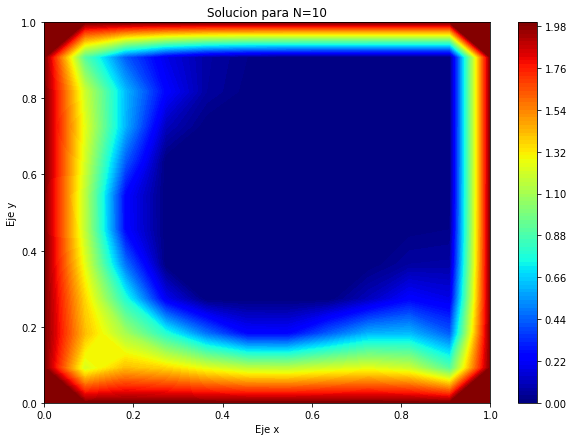

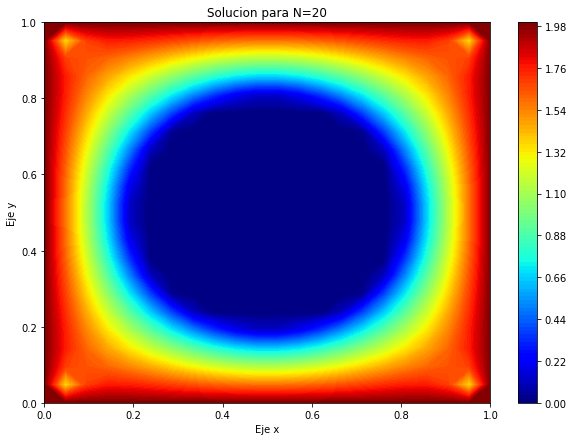

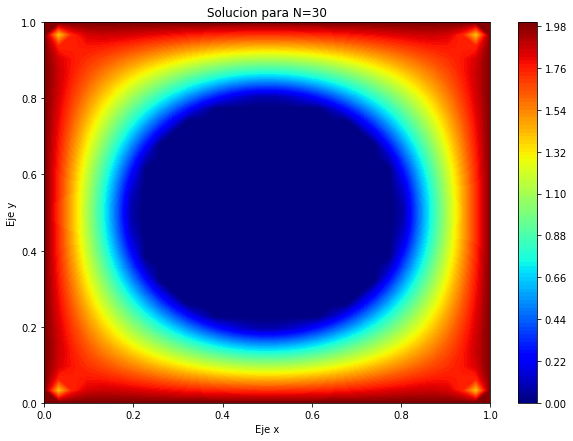

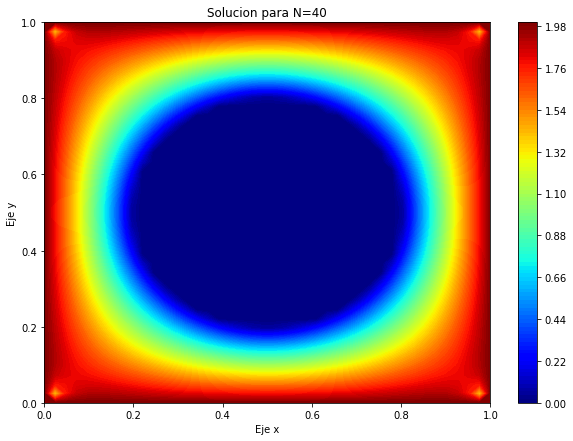

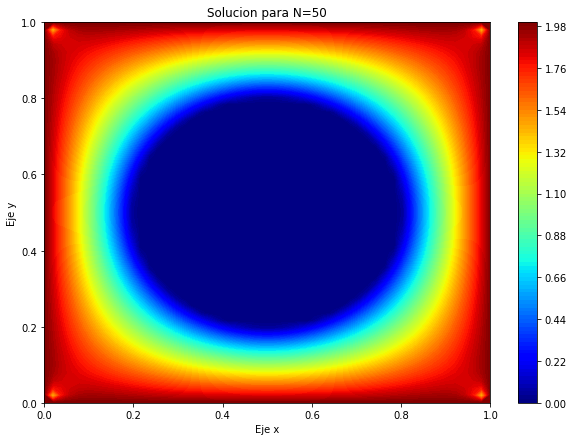

In [ ]:
for i in range(1,6):
    solucion,indices=solve2(10*i)
    visualiza2(solucion,indices,10*i)

## Comentario:
Es posible observar que a partir de un N=20 la disposicion geométrica al interior de la grilla se hace visible, es decir es posible observar la perforacion al interior del dominio, de la misma manera al aumentar N la particion es mas fina, de ahi que los contornos tomen mayor definision.
Además, dado que el operador se puede interpretar como una ecuacion de calor, es posible notar que a medida que nos alejamos de las condiciones de borde en el contorno del rectangulo, la temperatura tiende a disminuir (el calor se 'disipa') hasta llegar a la perforacion. 

**P5.** ¿Qué sucede con el condicionamiento de la matriz utilizando la fórmula de la Parte a?¿Cómo adaptaría su código para el caso $f\neq 0$?

1.-En el ultimo caso la matriz no es simetrica, luego no se puede utilizar la formulacion de la primera parte para calcular su condicionamiento, asi se debe proceder por la formulacion de la multiplicacion de la norma de ella con su inversa.

2.-El codigo se adaptaria de tal manera que se debiese redefinir el vector $b_{h}=f_{h}+\frac{g_{h}}{h^{2}}$ donde $f_h$ es la funcion evaluada en los puntos de la grilla y g es la condicion de borde.